### QuasarNET: the Quality Assesment notebook

This notebook will walk you through how to run [QuasarNET](https://arxiv.org/pdf/1808.09955.pdf]):
 * load training and validation data
 * train the network (on a small training sample, optional)
 * load pre-trained weights
 * plot example spectra
 * produce QA plots and confusion matrix

#### Installation instructions (requires python3):
##### - on a standard system

```bash
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
pip install -r requirements.txt --user
python setup.py install --user
```

##### - at NERSC (e.g. if you wish to run this notebook at jupyter.nersc.gov)

```bash
conda create -n qnet python=3 qnet scipy numpy fitsio h5py ipykernel
source activate qnet
python -m ipykernel install --user --name qnet --display-name qnet
pip install tensorflow
pip install keras>=2.2.4
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
python setup.py install
```

#### - downloading the data 
These data are a reprocessing of data release 12 (DR12) of the Sloan Digital Sky Survey (https://www.sdss.org/dr12/)

They are available on Kaggle: https://www.kaggle.com/ngbusca/qnet_data

A practical way to download the data is to use the [kaggle-api](https://github.com/Kaggle/kaggle-api), which will allow you to do it from the command line. Otherwise you can simply click the `download` link on the website.

Download the data to the `QuasarNET/data/` directory.

#### - download the pre-trained weights
The pre-trained weights are available at: https://www.kaggle.com/ngbusca/qnet_trained_models

Download the weights to the `QuasarNET/weights/` directory.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import fitsio
from keras.optimizers import Adam
from keras.models import load_model
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, wave, objective
from quasarnet.utils import process_preds, absorber_IGM
%matplotlib inline

Using TensorFlow backend.


#### Load the validation and training data

The full data sample was divided into 8 80/20 training/validation splits and pre-trained weights are available for each split. The random split to load is controled by the `isplit` variable.

The next cell loads first the truth table, the full data sample and the chosen training sample.
It finally excludes the training data from the full sample to form the validation sample.

The full data sample (~560,000 spectra) is abour 4GB and is fully loaded in memory. If your computer has less memory than that, set the nspec variable below to load a smaller number of spectra.

In [2]:
## set nspec to the number of spectra to load or to None for the full sample
nspec = None
isplit=0
truth_file=(['../data/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['../data/data_dr12.fits'], truth, nspec=nspec)

data_file = '../data/data_train_{}.fits'.format(isplit)
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]
w = np.in1d(tids_full, tids_train)
X_train = X_full[w]
Y_train = Y_full[w]
z_train = z_full[w]
bal_train = bal_full[w]

## to get the validation data, first read everything, 
## then remove the spectra in the training sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val = X_full[w]
Y_val = Y_full[w]
z_val = z_full[w]
bal_val = bal_full[w]

INFO: reading data from ../data/data_dr12.fits
INFO: removing 20766 spectra missing in truth
INFO: found (617289,) spectra in file ../data/data_dr12.fits
INFO: removing 2567 spectra with zero weights
INFO: removing 7 spectra with zero flux


#### Define the "features" that the network is trained to recognize

The features are defined by their rest wavelength. 
A dictionary `{feature_name:feature_wavelength}` is defined in `quasarnet.util.absorber_IGM`, which currently contains typical quasar broad emission lines. It could be easily extended to include other features by extending the dictionary.

In [3]:
lines=['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal=['CIV(1548)']

#### Train the network (optional).

The best way to train the network is to use a multicore computer. Training over 100 epochs on a full training sample takes ~24h on a standard 24 core unit, and ~7 hours on a Cori/NERSC node (64 cores).

As an example, the following two cells will instantiate the model (first cell) and run the training (second cell) on a single epoch and fewer training spectra. You can run the second cell many times to train over many epochs.

In [4]:
ntrain = 10000
nbins = X_train.shape[1]
model = QuasarNET((nbins,1), nlines=len(lines)+len(lines_bal))
optimizer = Adam()
loss = [custom_loss]*(len(lines)+len(lines_bal))
model.compile(optimizer=optimizer, loss=loss, metrics=[])
objective, sample_weight = objective(z_train[:ntrain],Y_train[:ntrain],bal_train[:ntrain],lines=lines,lines_bal=lines_bal)

In [5]:
loss_history = model.fit(X_train[:ntrain,:,None], objective, epochs=1, batch_size=32, sample_weight=sample_weight)

Epoch 1/1
10000/10000 [==============================] - 52s 5ms/step - loss: 2.7934 - conc_box_0_loss: 0.3281 - conc_box_1_loss: 0.4015 - conc_box_2_loss: 0.4484 - conc_box_3_loss: 0.4903 - conc_box_4_loss: 0.4109 - conc_box_5_loss: 0.2359 - conc_box_6_loss: 0.4782


#### Load a pre-trained model

The following cell loads pre-trained weights for the network, corresponding to the split defined earlier. The pre-training was done over the full training data sample and 200 epochs.

In [6]:
model = load_model('../weights/qn_train_{}.h5'.format(isplit),custom_objects={'custom_loss':custom_loss})

#### Example spectra

Let's now take a look at the network output by examining a few examples. If you skipped loading the pre-trained weights you will be looking at the model you trained (it's actually not that bad!).

The network outputs confidences and positions of the features defined earlier. The following plot shows a spectrum from the validation sample and the detected features. You can change the index `ival` to change the spectrum to be shown.

INFO: nspec = 1, nboxes=13


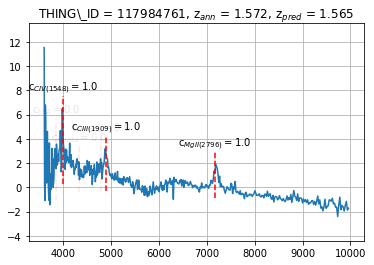

In [7]:
ival = 10
p=model.predict(X_val[ival:ival+1,:,None])
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)
plt.plot(wave, X_val[ival])
plt.title(r'THING\_ID = {}, z$_{{ann}}$ = {}, z$_{{pred}}$ = {}'.format(tids_val[ival],z_val[ival],round(zbest[0],3)))
m = X_val[ival].min()
M = X_val[ival].max()
plt.grid()
plt.ylim(m-2,M+2)
for il,l in enumerate(lines):
    lam = absorber_IGM[l]*(1+z_line[il])
    w = abs(wave-lam)<100
    m = X_val[ival,w].min()-1
    M = X_val[ival,w].max()+1
    plt.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il])
    plt.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,0],3)),
             horizontalalignment='center',alpha=0.1+0.9*c_line[il])
    

#### Quality Assesment
##### Purity and completeness (all redshift confused)

QuasarNET assumes a spectrum corresponds to a quasar if there are at least `ndetect` features detected with a confidence higher than a threshold confidence (`c_th`). The redshift is defined as that of the most confident line.

The following cells calculate the predictions of the network on the validation sample and plot the purity and completeness as a function of threshold confidence and minimum number of detected lines.

In [8]:
## predict the validation sample
print('calculating predictions')
p_val = model.predict(X_val[:,:,None])
print('done')
c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p_val, lines, lines_bal)

calculating predictions
done
INFO: nspec = 62395, nboxes=13


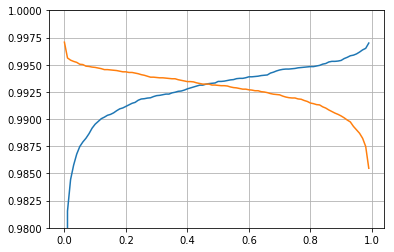

In [9]:
c_th=np.arange(0,1,0.01)
pur = c_th*0
com = c_th*0
isqso_truth = (Y_val.argmax(axis=1)==2) | (Y_val.argmax(axis=1)==3)
dv_max = 6000./300000.
zgood = (z_val>0) & (abs(zbest-z_val) < dv_max*(1+z_val))
ndetect = 2
for i,cth in enumerate(c_th):
    isqso_qn = (c_line>cth).sum(axis=0)>=ndetect
    ntrue_positives = (isqso_qn & zgood).sum()
    pur[i] = ntrue_positives/isqso_qn.sum()
    com[i] = (isqso_qn & zgood & isqso_truth).sum()/isqso_truth.sum()
    
plt.plot(c_th, pur)
plt.plot(c_th, com)
plt.ylim(0.98,1.0)
plt.grid()

#### Quality Assesment
##### Purity and completenss vs. redshift

The following plot show the purity and completeness vs. redshift. 

For a given redshift interval, defined using the network predictions, the purity is the fraction of spectra in the sample that have a predicted redshift better than 6000 km/s from the true redshift ( classification).

For a given redshift interval, defined using the true redshift, the completeness is the fraction of quasar spectra in the sample that the network detects with a redshift better than 6000 km/s from the true redshift.

/global/homes/n/nbusca/.conda/envs/qnet/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/global/homes/n/nbusca/.conda/envs/qnet/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


(0.96, 1.001)

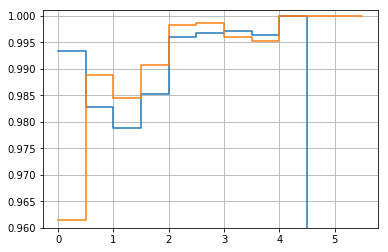

In [10]:
c_th = 0.7
ndetect = 1
isqso_qn = (c_line>c_th).sum(axis=0)>=ndetect

dz_int = 0.5
zmin = 0
zmax = 7
z_int = np.arange(zmin+dz_int/2,zmax+dz_int/2,dz_int)
pur_z = z_int*0
com_z = z_int*0
for i, zint in enumerate(z_int):
    w0 = isqso_qn & zgood & (abs(zbest-zint)<dz_int/2)
    w1 = isqso_qn & (abs(zbest-zint)<dz_int/2)
    pur_z[i] = w0.sum()/w1.sum()
    
    w0 = isqso_qn & isqso_truth & zgood & (abs(z_val-zint)<dz_int/2)
    w1 = isqso_truth & (abs(z_val-zint)<dz_int/2)
    com_z[i] = w0.sum()/w1.sum()
    
plt.step(z_int-dz_int/2, pur_z, where='post')
plt.step(z_int-dz_int/2, com_z, where='post')
plt.grid()
plt.ylim(0.96,1.001)

#### Quality assesment
##### Confusion matrix

The following cell computes the confusion matrix, i.e. the fraction of spectra in the true class i that are classified in class j by the network.

Note that while the true classes are `STAR`, `GALAXY`, `QSO LOZ`, `QSO HIZ`, the network classifies into `NOT QSO`, `QSO LOZ`, `QSO HIZ`. 

In [11]:
nspec, nclass = Y_val.shape
classes = ['STAR','GAL','Q_LZ','Q_HZ','BAD']
classes_qn = ['NOT_Q','Q_LZ','Q_HZ']
nclass_qn = 3
conf_mat=np.zeros((nclass, nclass_qn))
class_qn = np.zeros((3,nspec), dtype=bool)
class_qn[0] = ~isqso_qn
class_qn[1] = isqso_qn & (zbest<2.1)
class_qn[2] = isqso_qn & (zbest>=2.1)
print('{:^6} | '.format(""),end="")
print('{:^6} | '.format('NSPEC'),end="")
for c in classes_qn:
    print('{:^6} | '.format(c),end="")
print("")
for i in range(nclass):
    w = Y_val.argmax(axis=1)==i
    print('{:^6} | '.format(classes[i]),end="")
    print('{:^6} | '.format(w.sum()),end="")
    for j in range(nclass_qn):
        conf_mat[i,j] = (w & class_qn[j]).sum()/w.sum()
        print("{:^6} | ".format(round(conf_mat[i,j]*100,2)), end="")
    print("")

       | NSPEC  | NOT_Q  |  Q_LZ  |  Q_HZ  | 
 STAR  | 24060  | 99.65  |  0.28  |  0.07  | 
 GAL   |  2485  |  96.1  |  3.78  |  0.12  | 
 Q_LZ  | 12622  |  0.91  | 98.78  |  0.31  | 
 Q_HZ  | 21872  |  0.11  |  0.25  | 99.63  | 
 BAD   |  1356  |  76.7  | 17.04  |  6.27  | 
